# <center> COMP 562 : Inroduction to Machine Learning </center>
## <center> <font color='red'>Lecture 11 : Unsupervised Learning, Mixture Models, EM Algorithm </font> </center> 
### <center> Mahmoud Mostapha </center> 
### <center> Department of Computer Science -- UNC Chapel Hill</center>
###  <center> October 1, 2018 </center>

# COMP 562 – Lecture 11

Plan for today

1. Unsupervised learning
2. Mixture models
3. EM algorithm
    

$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ \big| }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\EE}{\mathbb{E}}
\renewcommand{\KL}{\textrm{KL}}
\renewcommand{\Bound}{\mathcal{B}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
\renewcommand{\argmax}{\mathop{\textrm{argmax}}}
\renewcommand{\new}{\textrm{new}}
\renewcommand{\old}{\textrm{old}}
$$

# Unsupervised Learning

In supervised learning, data is given in form

$$
\Data = \{(\xx_i,\yy_i) \mid i=1,...N\}
$$

There is a feature/predictor vector $\xx$ and a target variable $\yy$

In unsupervised learning this distinction disappeares

$$
\Data = \{\xx_i \mid i=1,...N\}
$$

# Examples of Unsupervised Learning

* Dimensionality reduction -- lossy compression 
* Clustering -- assigning each point to a representative cluster
  * Note: in classification groups are known, in clustering they are learned
* Deconvolution -- splitting mixed signals such as instruments or speakers in sound signal

Applications
* Data summarization/compression
* Denoising, outlier detection
* Feature construction

# Clustering

We will first look at a very simple -- and popular -- clustering algorithm called **K-means**

* Randomly choose K cluster center locations (means or centroids)
* Loop until convergence
    1. Assignment of samples to the closest of the K centroids
    2. Re-estimate the cluster	centroids or means based on	the	data assigned to each cluster	

<img src="./Images/KMeans.gif" width="520" align="center"/>

In [25]:
import numpy
import matplotlib.pyplot as plt
import time
from IPython import display
%matplotlib inline
def generate_data(N,d,K,proby,mus,A=None):    
    if A is None:
        A = numpy.eye(d)
    ys = [0]*N
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        x = numpy.dot(A,z) + mus[:,ys[i]]  
        xs[:,i] = x[:,0]
    return xs,ys

def plot_samples(xs,ys,mus=None,colors=['r','g','b','k','c','m']):
    if not ys is None:        
        K = numpy.max(ys)+1        
        for c in range(K):
        # indices of samples assigned to class c
            ind = [i for i in range(N) if ys[i]==c]
            plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label='Samples in cluster '+str(c))    
            if not mus is None:
                plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
                plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)
        plt.legend(loc=2, bbox_to_anchor=(1,1))
    else:
        plt.plot(xs[0,:],xs[1,:],'.')
            

def plot_samples_post(xs,qs,mus=None,colors=['r','g','b','k','c','m']):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)

Text(0.5,1,'Data')

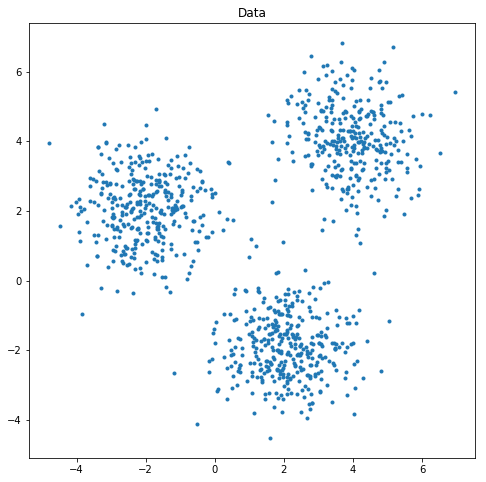

In [26]:
N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
numpy.random.seed(1)
xs,ys = generate_data(N,d,K,proby,mus)
fig = plt.figure(figsize=(8, 8))
plot_samples(xs,None,mus)
plt.title('Data')

In [27]:
def kmeans(xs,K,iterations,tolerance=1e-7, just_last=False,delay=1):
    
    # dimensions of data
    d,N = xs.shape
    
    # random initialization of centers
    data_mean = numpy.mean(xs,axis=1)[:,numpy.newaxis]
    mus = numpy.random.randn(d,K) + data_mean
    
    # cluster assignments using 1-hot representation
    ph = numpy.zeros((K,N))
    # distance from each cluster center to each point
    last_objective = numpy.finfo('d').max
    for it in range(iterations):
        # compute distance between samples and cluster centers (mus)
        # recognize this as vectorized form of
        # x'x - 2.0 x'mu 
        mus_sq = numpy.asmatrix(numpy.sum(mus**2.0,axis=0)).transpose()
        mus_xs = numpy.dot(mus.transpose(),xs)
        xs_sq = numpy.sum(xs**2.0,axis=0)
        distance =  mus_sq  - 2.0*mus_xs + xs_sq
        
        # objective is sum of distances from each sample
        # to its closest cluster
        objective = numpy.sum(numpy.min(distance,axis=0))
        
        # find closest clusters all at once
        h = numpy.argmin(distance,axis=0).transpose()        
        
        # convert the closest cluster id to one-hot
        # representation
        ph[:] = 0
        for (i,v) in enumerate(h):
            ph[v,i] = 1.0
         
        # visualization
        if not just_last:
            #plt.figure()
            plt.cla()
            plot_samples(xs,h,mus)
            plt.title('Iteration: {} Objective: {}'.format(it,objective))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(delay)
              
        # check whether sufficient change has occurred
        if last_objective - objective < tolerance:
            break
        else:           
            last_objective = objective       
           
        # update each cluster center with mean of samples in that cluster
        # make sure not to divide by 0 -- in case of an empty cluster
        mus = numpy.dot(xs,ph.transpose())/(1e-5 + numpy.sum(ph,axis=1)) 
        
    plt.close()
    if just_last:
        fig = plt.figure(figsize=(8, 8))
        plot_samples(xs,h,mus)
        plt.title('Final after {} iterations with objective {}'.format(it,objective))
    return h,mus

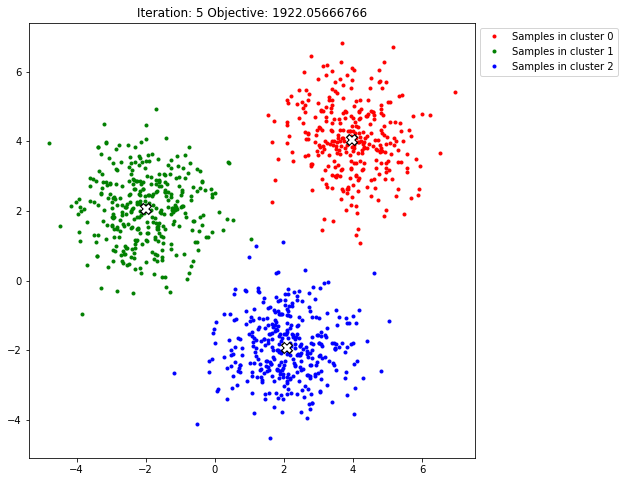

In [28]:
numpy.random.seed(1)
fig = plt.figure(figsize=(8, 8))
xs,ys = generate_data(N,d,K,proby,mus)
numpy.random.seed(1)
kmeans(xs,K=3,iterations=100,tolerance=1e-3,delay=2); 

Text(0.5,1,'Poor initialization')

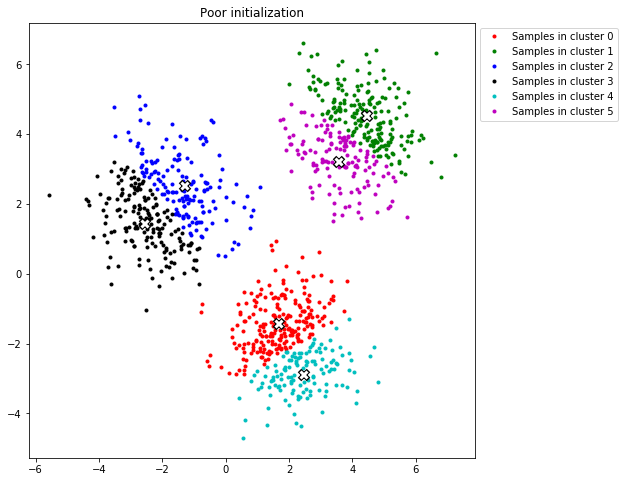

In [29]:
N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
numpy.random.seed(6)
xs,ys = generate_data(N,d,K,proby,mus=mus)
fig = plt.figure(figsize=(8, 8))
kmeans(xs,K=6,iterations=30,tolerance=1e-7,just_last = True);
plt.title('Poor initialization')

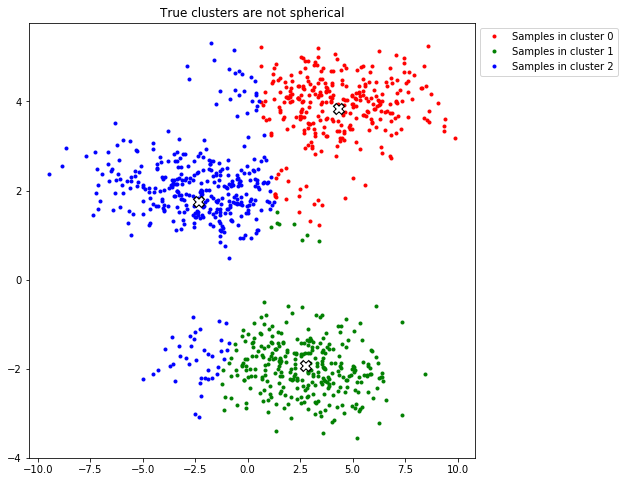

In [30]:
numpy.random.seed(7)
A = 1.4*numpy.random.randn(2,2)
fig = plt.figure(figsize=(8, 8))
xs,ys = generate_data(N,d,K,proby,mus,A)
kmeans(xs,K=3,iterations=10,tolerance=1e-3,just_last = True);
plt.title('True clusters are not spherical');

# K-means Observations

1. Initialization is random -- means of the clusters are slightly preturbed versions of data mean
2. Clusters are assumed to be spherical
3. Must manually choose K
3. Clusters can have zero members -- make sure there is no division with zero 

```
mus = numpy.dot(xs,ph.transpose())/(1e-5 + numpy.sum(ph,axis=1))
```
4. There are local minima
   * Non-trivial: poor initialization, too small or too large K
5. Multiple restarts -- from different initializations -- can lead to better solutions


# Clustering Methods

<img src="./Images/Soft.PNG" width="1400" align="center"/>

# How do we Come up with an Algorithm such as K-means?

We will:

1. Write out a generative model for the data
2. Write out log-likelihood
3. Optimize log-likelihood

The twist compared to our previous model learning is in the fact that not all the variables are observed

Labels, indicating cluster membership, are **hidden** from us

# Mixture Models

Mixture models are suited to the data exhibit clusters, where each cluster is called **mixture component**

Data is given to us as $\Data = \{\xx_i \mid i=1,...N\}$

We introduce a random variable $h$ that tells us which cluster or mixture component the sample came from

<img src="./Images/GMM.gif" width="600" align="center"/>

# Mixture Models -- Generative Story

Each sample $\xx$ is generated by:
1. Selecting a cluster, according to some distribution $\pi = (\pi_1,...,\pi_K)$
$$
p(h) = \pi_h
$$
2. Using parameters of cluster $h$ generate the sample $\xx$
$$
p(\xx \mid h,\theta) = p(\xx \mid \theta_h)
$$

For example in **K-means**, you can think of $\theta_h$ as the mean of the cluster $h$

$$
p(\xx \mid \theta_h) = \prod_{j=1}^p \frac{1}{\sqrt{2\pi\sigma^2}} \myexp{-\frac{1}{2\sigma^2}(x_j - \theta_{h,j})^2}
$$

Text(0.5,1,'$h$ indicates cluster membership,\n$\\theta$ are cluster centers')

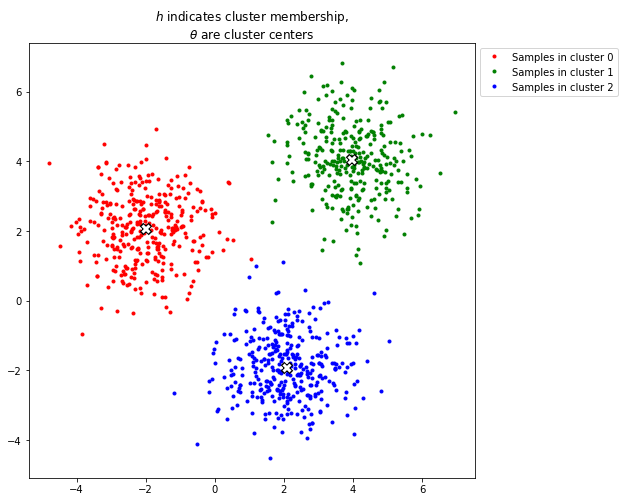

In [31]:
numpy.random.seed(1)
fig = plt.figure(figsize=(8, 8))
xs,ys = generate_data(N,d,K,proby,mus)
kmeans(xs,K=3,iterations=100,tolerance=1e-3,just_last=True); 
plt.title("$h$ indicates cluster membership,\n$\\theta$ are cluster centers")

# Mixture Models -- Generative Story

Note that generative model talks about how data might have been generated

We want to fit a model under which that data is most probable

To do so, we must write out log-likelihood 

$$
\loglik(\Theta) = \sum_i \log p(\xx_i \mid\Theta)
$$

and maximize it with respect to parameters $\Theta$


# Marginal Log-Likelihood 

For a single sample $\xx$, we know how to compute $p(h)$ and $p(\xx\mid h,\Theta)$ so we can obtain joint 

$$
p(\xx,h \mid \Theta) = p(h) p(\xx\mid h,\Theta)
$$

This is probability of the full configuration $\xx$ **and** cluster membership $h$

Our data does not contain information about cluster membership, just vectors $\xx$

**<font color='red'> How do we compute $p(\xx \mid \Theta)$?  </font>**

# Marginal Log-likelihood 

We can use the fact that

$$
p(\xx\mid\Theta) = \sum_h p(\xx,h \mid \Theta)  = \sum_h p(h)p(\xx\mid h,\Theta)
$$

**<font color='red'>  What is the interpretation of this sum? </font>**

# Marginal Log-likelihood
Now, we can express log-likelihood in terms of probabilities in our model

$$
\loglik(\Theta) = \sum_i \log p(\xx_i\mid\Theta) = \sum_{i=1}^N \log  \sum_{h_i} p(\xx_i,h_i\mid \Theta).
$$

Observations
1. For each sample $\xx_i$, we have corresponding cluster membership variable $h_i$
2. There is a sum under the log so we cannot push the log to probability terms

# Dealing with Difficult Objectives

Typically, when we run into an objective that is difficult to work with (for example log of sums above), we seek a closely related objective that is easier

Hence, we will not directly optimize the log-likelihood instead we will introduce a lower-bound on the log-likelihood which we can show is tight at the optimum

To accomplish this we a bit of math that you may not be familar with

1. Convex and concave functions
2. Jensen's inequality

# Concave and Convex Functions 

A function $f(x)$ is concave if

$$
f(\lambda x + (1-\lambda)y) \geq \lambda f(x)  + (1-\lambda)f(y)
$$

for any $\lambda \in [0,1]$

Examples of concave functions are log, exp, square, etc.

Similarly, a function $f(x)$ is convex if

$$
f(\lambda x + (1-\lambda)y) \leq \lambda f(x)  + (1-\lambda)f(y)
$$

for any $\lambda \in [0,1]$

The negative of a concave function is convex

Text(0.5,1,'NegLog is convex')

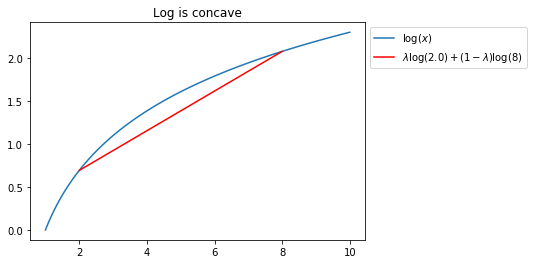

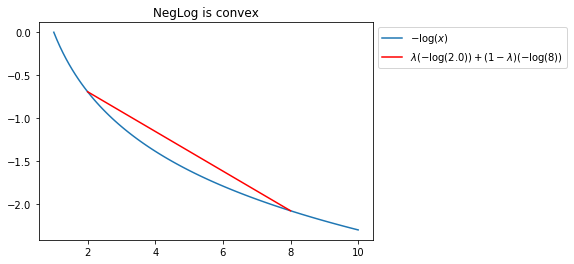

In [32]:
x = numpy.linspace(1.,10.0,100)
px = [2.0,8.0]

plt.plot(x,numpy.log(x),label ='$\log(x)$')
plt.plot(px,numpy.log(px),'r',label = '$\lambda \log(2.0) + (1-\lambda) \log(8)$')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.title('Log is concave')
plt.figure()
plt.plot(x,-numpy.log(x),label ='$-\log(x)$')
plt.plot(px,-numpy.log(px),'r',label = '$\lambda (-\log(2.0)) + (1-\lambda) (-\log(8))$')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.title('NegLog is convex')

# Jensen's Inequality

Jensen's inequality

$$
f(\EE[H]) \geq \EE[f(H)]
$$

where

$$
\EE[H] = \sum_h p(H=h)h.
$$ 

and $f$ is concave

# Bounding log-Likelihood

Starting with log-likelihood
$$
\loglik(\Theta) = \sum_i \log p(\xx_i\mid\Theta) = \sum_{i=1}^N \log  \sum_{h_i} p(\xx_i,h_i\mid \Theta).
$$
we introduce distributions $q_i(h_i)$ and multiply and divide by them
$$
\begin{aligned}
\loglik(\Theta) &= \sum_i \log p(\xx_i\mid\Theta) = \sum_{i=1}^N \log  \sum_{h_i} \color{red}{\frac{q_i(h_i)}{q_i(h_i)}} p(\xx_i,h_i\mid \Theta)\\
&= \sum_{i=1}^N \log  \sum_{h_i} q_t(h_i) \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) } \\
&= \sum_{i=1}^N \log \EE_{q_i}\left[\frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) }\right] \\
&\geq \sum_{i=1}^N \EE_{q_i}\left[\log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) }\right] \\
&= \sum_{i=1}^N \sum_{h_i} q_i(h_i) \log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) } 
\end{aligned}
$$

# Bounding log-Likelihood

Starting with log-likelihood
$$
\loglik(\Theta) = \sum_i \log p(\xx_i\mid\Theta) \geq  \sum_{i=1}^N \sum_{h_i} q_i(h_i) \log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) }  = \mathcal{B}(\Theta,q)
$$

Natural questions that arise:
1. Where do we get $q_i$s? 
2. Does optimizing bound result in the same $\Theta$?
$$
\argmax_{\Theta}\loglik(\Theta)\stackrel{?}{=}\argmax_{\Theta}\mathcal{B}(\Theta,q) 
$$


# Bounding log-Likelihood

Natural questions that arise:

*  Where do we get $q_i$s? 
 * A: We use posterior probabilities $p(h_i \mid \xx_i,\Theta)$


*  $\argmax_{\Theta} \loglik(\Theta) \stackrel{?}{=} \argmax_{\Theta} \mathcal{B}(\Theta,q)$? 
 * A: Yes, if we use exact posterior probabilities in place of $q_i$s the two objectives coincide and optimal $\Theta$s are the same

# Expectation-Maximization (EM) Algorithm

Hence we can maximize the bound $\mathcal{B}(\Theta)$ by iterating

1. (E-step) Computing the optimal 
$$
q^{\new}_i = \argmax_{q_i} \mathcal{B}(\Theta^{\old},q) 
$$
2. (M-step) Updating $\Theta$ given current $q_i(h_i)$
$$
\Theta^{\new} = \argmax_{\Theta} \mathcal{B}(\Theta,q^{\new}) 
$$

Recall for a moment the K-means algorithm. It alternated analogous two steps:
1. Assigning each sample to a cluster
2. Cluster center computation based on assignments

# EM Algorithm for Mixture of Gaussians without Covariance

The model
$$
\begin{aligned}
p(h\mid \alpha) &= \alpha_h \\
p(\xx \mid h,\mu) &= (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_{h_t})^T(\xx - \mu_{h_t})} \\
\end{aligned}
$$
is a variant of **Mixture of Gaussians**

$\alpha_c$ is an a-priori probability that a sample comes from class $c$ -- also called **mixing proportion**

The bound 
$$
\begin{aligned}
\Bound(\Theta,q) &= \sum_{i=1}^N \sum_{h_i} q_i(h_i) \log \frac{ p(\xx_i,h_i\mid \Theta) }{ q_i(h_i) } \\
&=  \sum_{i=1}^T \sum_{h_i} q_i(h_i) \left[ \log \alpha_{h_i} -\frac{d}{2} \log (2\pi) -\frac{1}{2}(\xx - \mu_{h_i})^T(\xx - \mu_{h_i}) \right] \\
&- \sum_{i=1}^T \sum_{h_i} q_i(h_i) \log q_i(h_i)
\end{aligned}
$$
In this case $\Theta = (\alpha_1,...,\alpha_K,\mu_1, ...,\mu_K)$


# E-step

In E-step we optimize $q$s given $\Theta$

$$
\begin{aligned}
q^{\new}_i &= \argmax_{q_i} \mathcal{B}(\Theta^{\old},q) \\
\end{aligned}
$$

In general, we can take derivatives, equate them to zero, and solve:

$$
\nabla_{q_i}  \mathcal{B}(\Theta^{\old},q)  = 0 
$$

We can show that in our case, the E-step updates are:

$$
\begin{aligned}
q_i(h_i = k) &= p(h_i =k \mid \xx_i, \mu)  = \frac{p(\xx_i,h_i = k \mid \mu)}{\underbrace{\sum_c p(\xx_i,h_i=c \mid \mu)}_{\textrm{same for all values of } k}}\\
 &\propto p(\xx_i,h_i = k\mid \mu) = p(h_i = k \mid \alpha) p(\xx \mid h_i=k,\mu) \\
        &=  \alpha_{k} (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h)}
\end{aligned}
$$ 

# E-step: Working in Log-Domain

If the data vectors are long, the computation of joint probabilities can yield very tiny probabilities

Rather than working with probabilities we work with log-probabilities. Hence we store 

$$
\log q_i(h_i = k) = \log p(\xx_i,h_i = k \mid \mu) - \log \sum_c p(\xx_i,h_i=c \mid \mu)
$$

If all the probabilities are stored in log-domain, then computation of their sum requires exponentation

$$
\log \sum_c p(\xx_i,h_i=c \mid \mu) = \log \sum_c\exp \ \underbrace{\log p(\xx_i,h_i=c \mid \mu)}_{\textrm{stored log-probability}}
$$

# E-step: Implementation

Given a function that computes $\log p(\xx,h|\Theta)$ for all samples and all classes called ```logjointp(x,Theta)```

```python
q = numpy.zeros((K,N)) # clusters x samples
q = logjointp(x,Theta) # compute all joints at once
q = q - logsumexp(q)   # normalizing across clusters
```

Note:
* $q$ is usually stored in a table of probabilities of size $K \times N$
* entry ```q[k,i]``` stores probability that $i^{\textrm{th}}$ sample came from a class $k$
* $\sum_{k} q_i(h_i=k) = 1$ -- columns of table ```q``` should sum to 1.0
* $\sum_i q_i(h_i=k)$ -- rows sum of table ```q``` a weighted count of samples in class $k$
* $\sum_{i=1}^N\sum_{h_i} q_i(h_i) = N$

# M-step

In M-step we optimize $\Theta$ given $q$s

$$
\Theta^{\new} = \argmax_{\Theta} \mathcal{B}(\Theta,q^{\new}) 
$$

In general, we can take derivatives, equate them to zero, and solve:

$$
\nabla_{\Theta}  \mathcal{B}(\Theta,q^{\new})  = 0 
$$

We can show that in our case, the M-step updates are:

$$
\begin{aligned}
\mu_k^* &= \frac{\sum_i q_i(k) \xx_i}{\sum_i q_i(k)} \\
\alpha^*_k &= \frac{\sum_i q_i(k)}{N}
\end{aligned}
$$

# M-step: Implementation

For our model -- mixture of Gaussians -- M-step updates $\mu$s an $\alpha$s, given current $q$

$$
\begin{aligned}
\mu_k^* &= \frac{\sum_i q_i(k) \xx_i}{\sum_i q_i(k)} \\
\alpha^*_k &= \frac{\sum_i q_i(k)}{N}
\end{aligned}
$$

```python
mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
alpha = numpy.sum(q,axis=1)/N
```
Note that `xs` is of size $d \times N$, `q` is of size $K \times N$, hence 
* `numpy.dot(xs,q.tranpose())` computes $\sum_i q_i(k) \xx_i$ 
* ` numpy.sum(q,axis=1)` computes $\sum_i q_i(k)$

In [33]:
def logsumexp(vec):
    m = numpy.max(vec,axis=0)    
    return numpy.log(numpy.sum(numpy.exp(vec-m),axis=0))+m

def plot_samples_post(xs,qs,mus=None,colors=['r','g','b','k','c','m'], 
                      highlight_samples=None,
                      label_means=False):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    if not highlight_samples is None:
        for (i,d) in highlight_samples:
            s = ''
            for j in range(3):
                if j>0:
                    s = s + '\n'
                s = s + '$p(h_{{{}}}={} |x_{{{}}})=${:1.4f}'.format(i,j,i,qs[j,i])
            if d==0:
                plt.annotate(s,xy=(xs[0,i]+0.5,xs[1,i]-1.0),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i]+0.5,xs[1,i],-0.5,0)
            else:
                plt.annotate(s,xy=(xs[0,i]-1,xs[1,i]-3),
                         bbox=dict(facecolor='white'),
                         fontsize=15)
                plt.arrow(xs[0,i],xs[1,i]-4.5,0,4.5)
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)            
            if label_means:
                plt.annotate('$\mu_{}$'.format(c),xy=(mus[0,c]+0.5,mus[1,c]-0.5),
                              bbox=dict(facecolor='white'),
                              fontsize=15)

In [34]:
def mog(xs,K,iterations=10, visualize=False,delay=1):
    d,N = xs.shape
    # compute mean and std of data, and convert to
    # column vectors using numpy.newaxis trick.
    data_mean = numpy.mean(xs,axis=1)[:,numpy.newaxis]
    data_std = numpy.std(xs,axis=1)[:,numpy.newaxis]
    # initialize means around the data mean but
    # ensure they are not exactly the same by adding
    # small amount of noise
    mus = data_mean + 0.01*data_std*numpy.random.randn(d,K) 
    xs_sq = numpy.sum(xs**2.0,axis=0)
        
    logalphas = numpy.array([-numpy.log(K)]*K)
    
    logconst = -(d/2.0)*numpy.log(2.0*numpy.pi)
    logliks = []
    for it in range(iterations):
        #E-step:
        mus_sq = numpy.sum(mus**2.0,axis=0)[:,numpy.newaxis]
        mus_xs = numpy.dot(mus.transpose(),xs)
        # compute log p(x,h) for all samples
        q = logalphas[:,numpy.newaxis] + logconst - 0.5*(mus_sq - 2.0*mus_xs + xs_sq)
        
        # loglikelihood is equal to sum(logsumexp(log(p(x,h))))
        loglik = numpy.sum(logsumexp(q))
        
        logliks.append(loglik)
        # normalize columns to get log(p(h|x)) for all samples
        q = numpy.exp(q - logsumexp(q))
        
        # M-step:
        mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
        logalphas = numpy.log(numpy.sum(q,axis=1)/N)
        
        if visualize:
            print "Iteration: {} Log-likelihood: {} ".format(it,loglik)
            plt.cla()            
            plot_samples_post(xs,q,mus,highlight_samples = [(121,0),(114,-1)],
                              label_means=it>0)
            plt.title(('Iteration {} Log-likelihood {} \n '+ 
                       'Red intensity = $p(h=0|x)$\n'+
                       'Green intensity = $p(h=1|x)$\n' +
                       'Blue intensity = $p(h=2|x)$').format(it,loglik),
                        multialignment='right')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(delay)

    plt.close()
    alphas = numpy.exp(logalphas)
    return mus,alphas,q,logliks

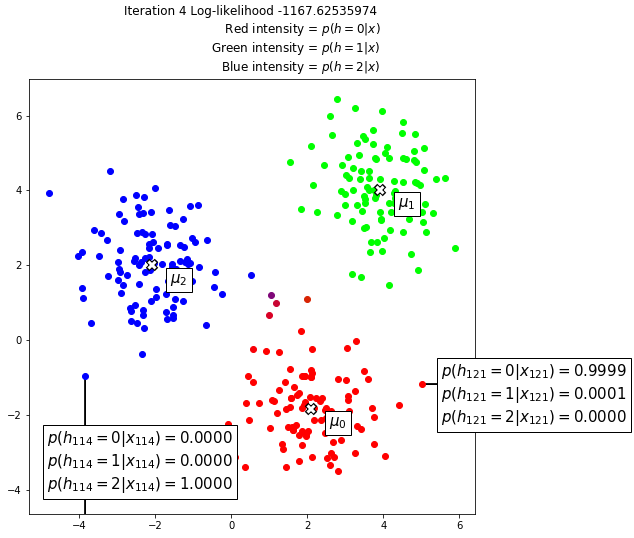

In [35]:
N = 300
d = 2
K = 3
proby = [1./K]*K
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
numpy.random.seed(1)
fig = plt.figure(figsize=(8, 8))
xs,ys = generate_data(N,d,K,proby,mus)
[mus,alphas,q,logliks] = mog(xs,3,iterations=5,visualize=True,delay=3);

Text(0,0.5,'Log-likelihood')

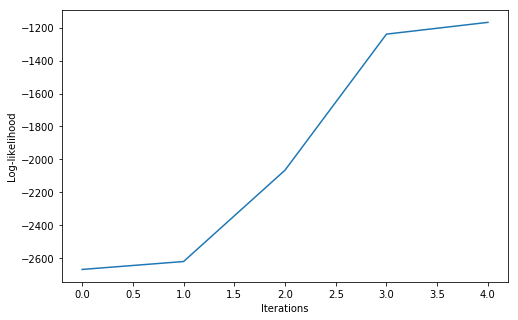

In [36]:
fig = plt.figure(figsize=(8, 5))
plt.plot(logliks)
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

# Today

* K-means
* Mixture models
* EM algorithm